### Geomagnetic Induction in Submarine Cable during the March 1989 Geomagnetic Storm
---
* __author__ = [Chakraborty, S.; Boteler, D. B. H.]
* __copyright__ = 
* __credits__ = []
* __license__ = MIT
* __version__ = 1.0
* __maintainer__ = Chakraborty, S.
* __email__ = shibaji7@vt.edu
* __status__ = Research

>  

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.fftpack
from scipy.stats import pearsonr

import bezpy
from gic.model.oml import OceanModel
from gic.model.utils import RecursiveNamespace
from gic.validation.simulate_synB_synT import CableAnalysis

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(["science", "ieee"])
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma", "DejaVu Sans",
                                   "Lucida Grande", "Verdana"]

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

%matplotlib inline

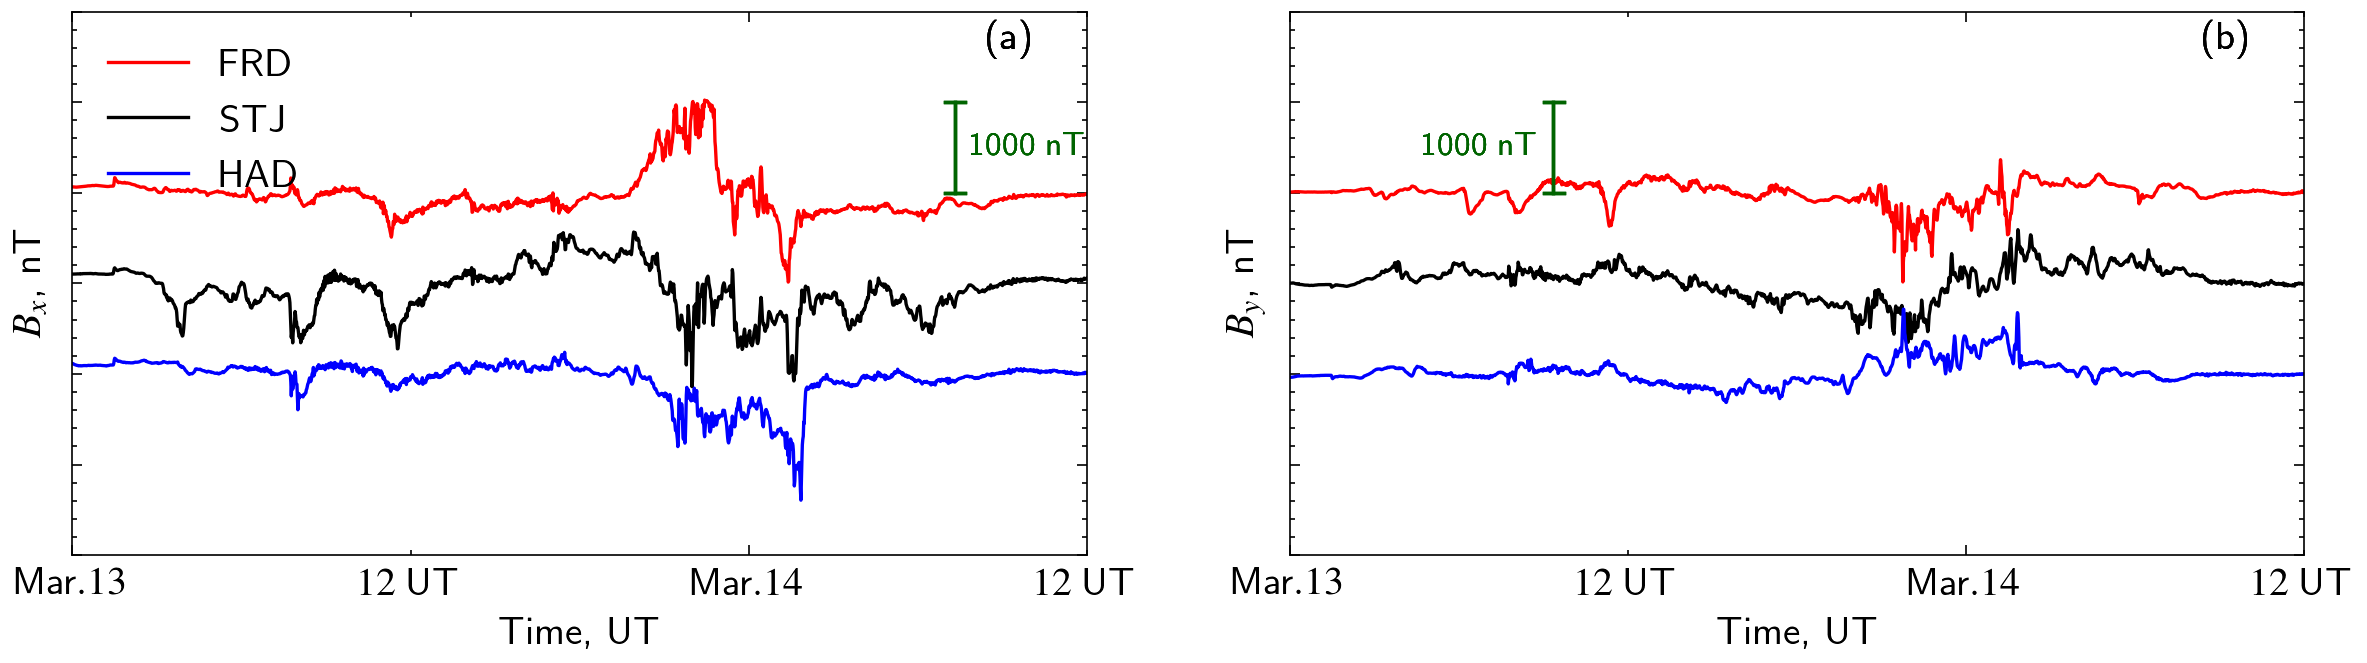

In [2]:
stns, coords = ["FRD", "STJ", "HAD"], ["XYZ", "XYZ", "HDZ"]
db="input/data/{year}/"
dates, frames = [dt.datetime(1989,3,12),dt.datetime(1989,3,13),dt.datetime(1989,3,14)], {}
for stn, coord in zip(stns, coords):
    o = pd.DataFrame()
    for d in dates:
        f = db.format(year=d.year) + "{stn}_{date}_{coord}.txt".format(stn=stn, 
                                                                       date=d.strftime("%Y%m%d"), 
                                                                       coord=coord)
        o = pd.concat([o, bezpy.mag.read_iaga(f)])
    frames[stn] = o

mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=240, figsize=(12, len(stns)))
multiplier, colors = [1, 0, -1], ["r", "k", "b"]
base=1000
for i, stn in enumerate(stns):
    frame = frames[stn]
    ax = axes[0]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.plot(frame.index, (base*multiplier[i])+frame.X-np.mean(frame.X), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_x$, nT", fontdict={"color": "k"})
    ax.set_ylim(-3000,3000)
    ax.axvline(frame.index.tolist()[-1000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2000, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.axhline(1000, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[-970], 1500, "1000 nT", ha="left", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_yticklabels([])
    ax.legend(loc=2)
    ax.text(0.95,0.95,"(a)",ha="right",va="center",transform=ax.transAxes)
    ax = axes[1]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter("%b.%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    ax.plot(frame.index, (base*multiplier[i])+frame.Y-np.mean(frame.Y), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_y$, nT", fontdict={"color": "k"})
    ax.axvline(frame.index.tolist()[2000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
    ax.axhline(1000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[1970], 1500, "1000 nT", ha="right", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-3000,3000)
    ax.set_yticklabels([])
    ax.text(0.95,0.95,"(b)",ha="right",va="center",transform=ax.transAxes)
axes[0].set_xlabel("Time, UT")
axes[1].set_xlabel("Time, UT")
fig.subplots_adjust(wspace=.2, hspace=.1)
fig.savefig("tmp/Bxy.Field.png", bbox_inches="tight")

2022-10-28 02:40:31.702 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.725 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.748 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.771 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.794 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.817 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.840 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.861 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields
2022-10-28 02:40:31.883 | INFO     | gic.model.oml:__init__:70 - Compile OM[] to calc O(floor) E- and B-Fields


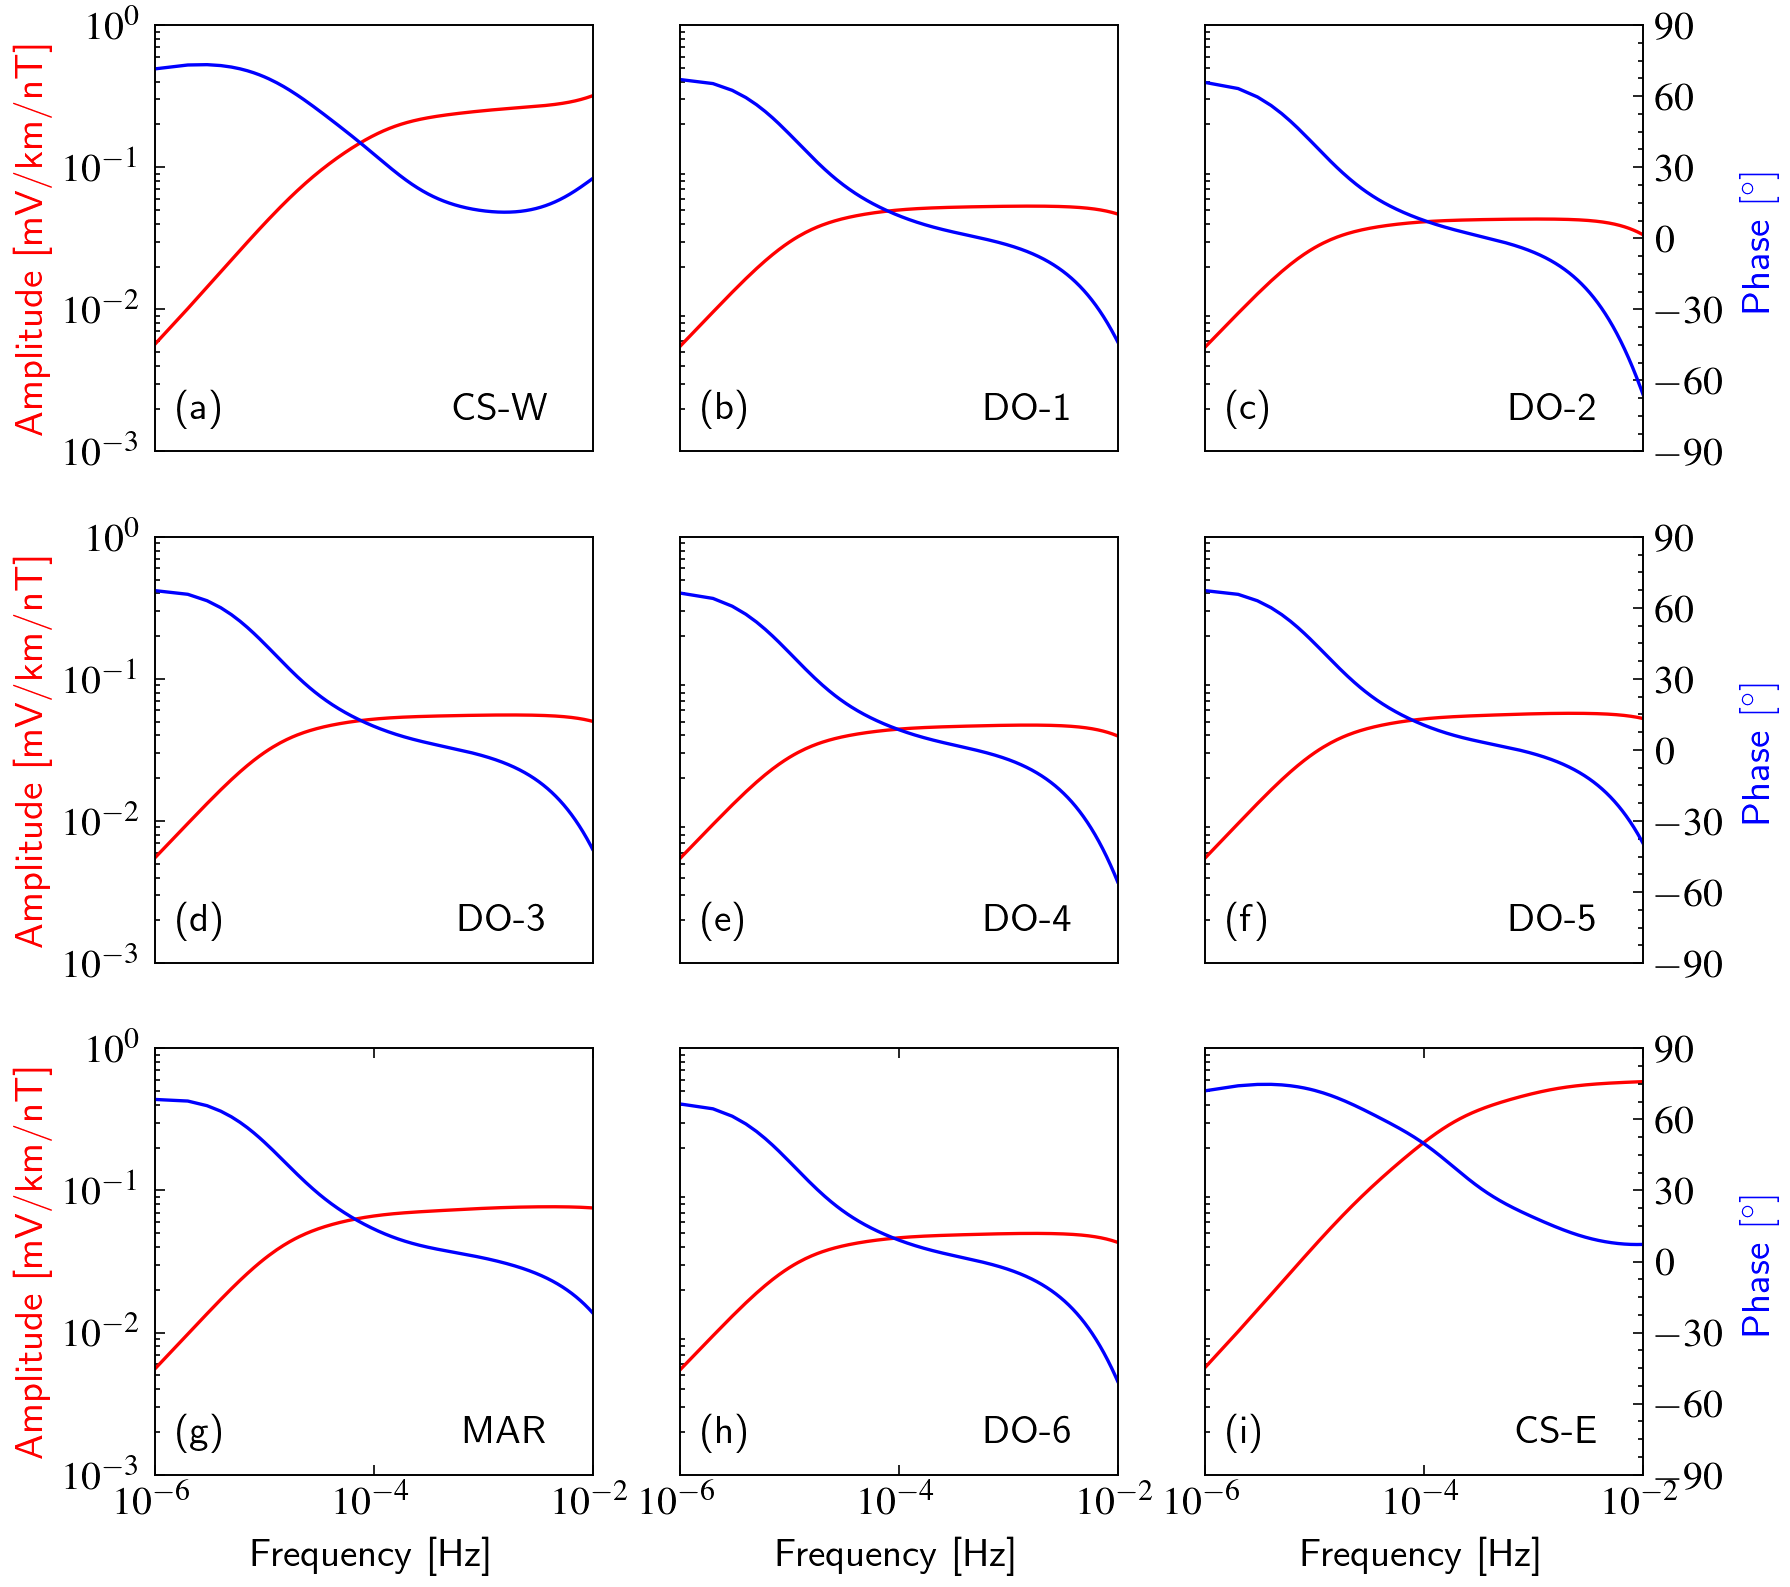

In [3]:
# Generate Ocean-Earth Models for 9 segments
segment_name = ["CS-W", "DO-1", "DO-2", "DO-3", "DO-4", "DO-5", "MAR", "DO-6", "CS-E"]
# Ocean resitivity
ocean_resistivity = 0.3
# Resistivities of the earth layers
earth_resistivities = np.array([3, 3000, 1000, 100, 10, 1])
# Thicknesses of the Ocan [index 0] the Earth layers
ocean_thicknesses = np.array([0.1, 4, 5.2, 4, 4.8, 4, 3, 4.5, 0.1])*1e3
# Thikness of the different earth layers at 9 segments
segments = {
    "CS-W": np.array([8, 15, 150, 236.9, 250, 340])*1e3,
    "DO-1": np.array([4, 10, 145, 247, 250, 340])*1e3,
    "DO-2": np.array([2, 10, 140, 252.8, 250, 340])*1e3,
    "DO-3": np.array([2, 10, 140, 254, 250, 340])*1e3,
    "DO-4": np.array([1, 10, 70, 324.2, 250, 340])*1e3,
    "DO-5": np.array([0.5, 10, 60, 335.5, 250, 340])*1e3,
    "MAR": np.array([0, 10, 25, 372, 250, 340])*1e3,
    "DO-6": np.array([1.5, 10, 70, 324, 250, 340])*1e3,
    "CS-E": np.array([3, 20, 120, 266.9, 250, 340])*1e3,
}
# Frequency limits
flim = [1e-6, 1e-2]
# List of all transfer functions
TxList = []
for i, s_name in enumerate(segment_name):
    ocean_model = {
        "depth": ocean_thicknesses[i], 
        "rho": ocean_resistivity,
    }
    # Create ocean-earth leayerd model
    om = OceanModel(
        segments[s_name], 
        earth_resistivities, 
        ocean_model=ocean_model, 
        flim=flim
    )
    # Get transfer function
    Tx = om.get_TFs()
    TxList.append(Tx)

# Plot transfer function (amplitude and phase)
labs = ["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)"]
fig = plt.figure(dpi=240, figsize=(8,8))
for i in range(9):
    ax = fig.add_subplot(331+i)
    ax.loglog(TxList[i].freq, np.abs(TxList[i].E2B), "r", lw=1.0, ls="-")
    if i in [6,7,8]: ax.set_xlabel(r"Frequency [Hz]")
    else: ax.set_xticks([])
    if i in [0,3,6]: ax.set_ylabel(r"Amplitude [mV/km/nT]", color="r")
    else: ax.set_yticks([])
    ax.set_xlim(1e-6,1e-2)
    ax.set_ylim(1e-3,1e0)
    ax.text(0.9, 0.1, segment_name[i], ha="right", va="center", transform=ax.transAxes)
    ax = ax.twinx()
    ax.semilogx(TxList[i].freq, np.angle(TxList[i].E2B, deg=True), "b", lw=1., ls="-")
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    if i in [2,5,8]: ax.set_ylabel(r"Phase $[^\circ]$", color="b")
    else: ax.set_yticks([])
    if i not in [6,7,8]: ax.set_xticks([])
    ax.set_ylim(-90, 90)
    _ = ax.set_xlim(1e-6,1e-2)
    ax.text(0.05,0.1,labs[i],ha="left",va="center",transform=ax.transAxes)
fig.subplots_adjust(wspace=0.2,hspace=0.2)

2022-10-28 02:40:33.735 | INFO     | gic.validation.simulate_synB_synT:__init__:57 - B-field run parameters
2022-10-28 02:40:33.736 | INFO     | gic.model.synthetic:__init__:93 - Reading B-field data
2022-10-28 02:40:33.894 | WARNING  | gic.model.cables:setup:418 - Into cable setup section
2022-10-28 02:40:33.895 | INFO     | gic.model.oml:__init__:70 - Compile OM[CS-W] to calc O(floor) E- and B-Fields
2022-10-28 02:40:33.898 | INFO     | gic.model.cables:compile_oml:223 - Synthetic 1 CS-W->OM(CS-W)
2022-10-28 02:40:33.899 | INFO     | gic.model.cables:calc_trasmission_line_parameters:250 - Cable width: 1.0
2022-10-28 02:40:33.995 | INFO     | gic.model.oml:__init__:70 - Compile OM[DO-1] to calc O(floor) E- and B-Fields
2022-10-28 02:40:33.998 | INFO     | gic.model.cables:compile_oml:223 - Synthetic 2 DO-1->OM(DO-1)
2022-10-28 02:40:33.998 | INFO     | gic.model.cables:calc_trasmission_line_parameters:250 - Cable width: 1.0
2022-10-28 02:40:34.093 | INFO     | gic.model.oml:__init__:7

2022-10-28 02:40:35.680 | INFO     | gic.model.cables:get_voltage_ends_of_cable:681 - Max(V) at the end (Component-Y), 56.76 37.27
2022-10-28 02:40:35.680 | INFO     | gic.model.cables:get_voltage_ends_of_cable:681 - Max(V) at the end (Component-X), 47.09 21.98
2022-10-28 02:40:35.998 | INFO     | gic.model.cables:get_voltage_ends_of_cable_section:694 - Max(V) at the end of Section-0(Component-Y), 56.76 47.91
2022-10-28 02:40:35.999 | INFO     | gic.model.cables:get_voltage_ends_of_cable_section:694 - Max(V) at the end of Section-0(Component-X), 47.09 34.33
2022-10-28 02:40:36.198 | INFO     | gic.model.cables:get_voltage_ends_of_cable_section:694 - Max(V) at the end of Section-1(Component-Y), 47.91 51.39
2022-10-28 02:40:36.198 | INFO     | gic.model.cables:get_voltage_ends_of_cable_section:694 - Max(V) at the end of Section-1(Component-X), 34.33 33.24
2022-10-28 02:40:36.474 | INFO     | gic.model.cables:get_voltage_ends_of_cable_section:694 - Max(V) at the end of Section-2(Component

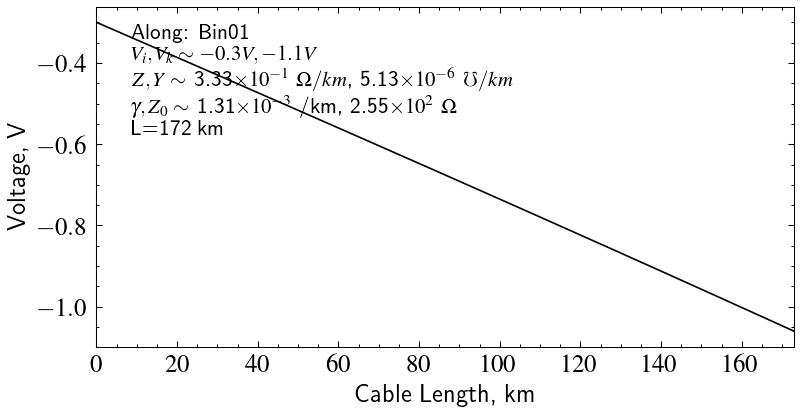

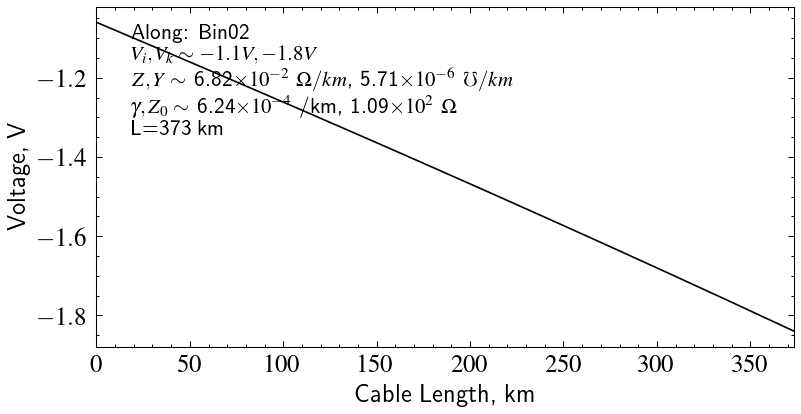

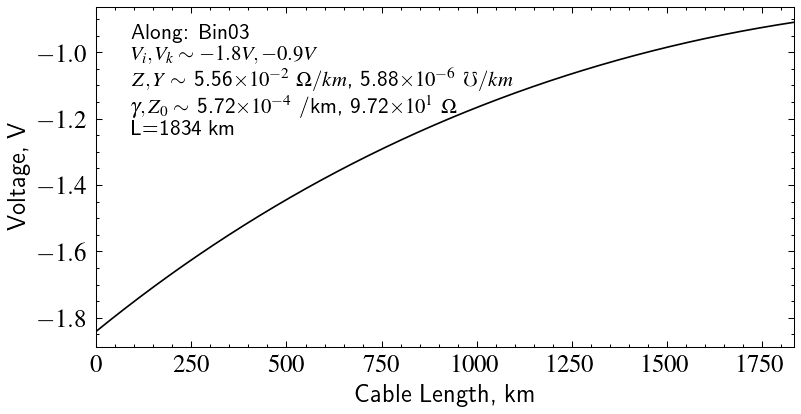

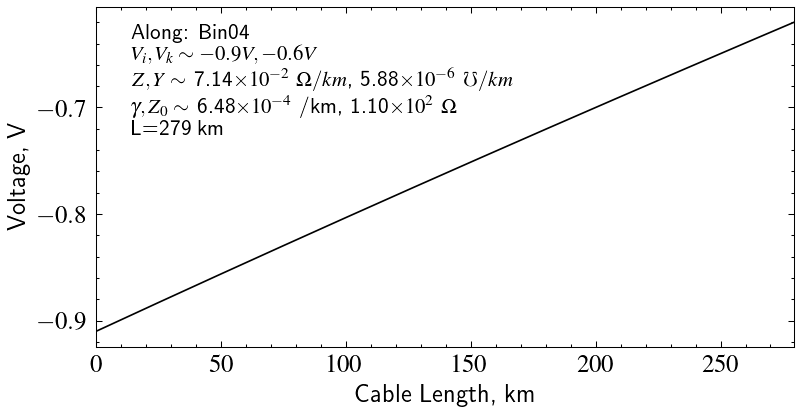

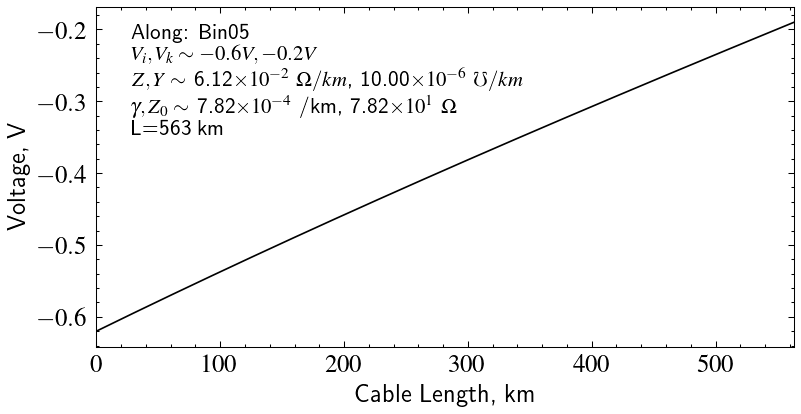

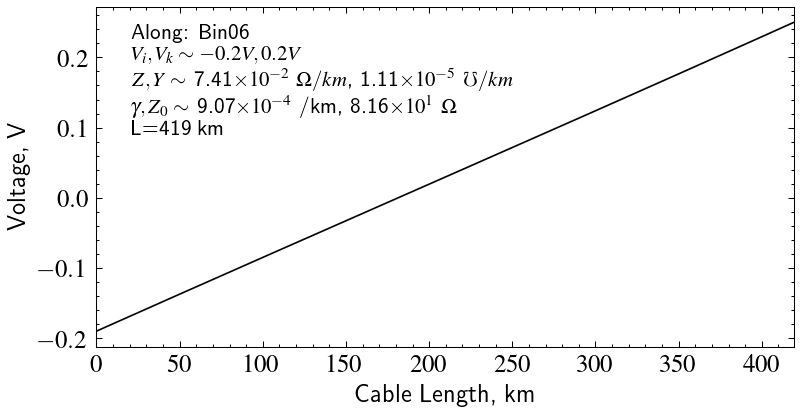

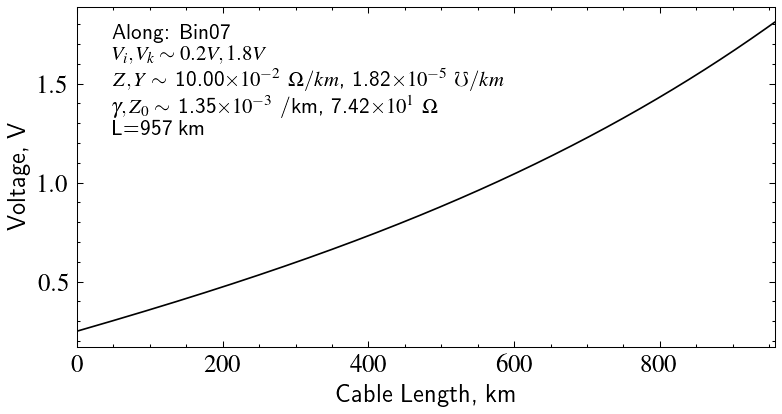

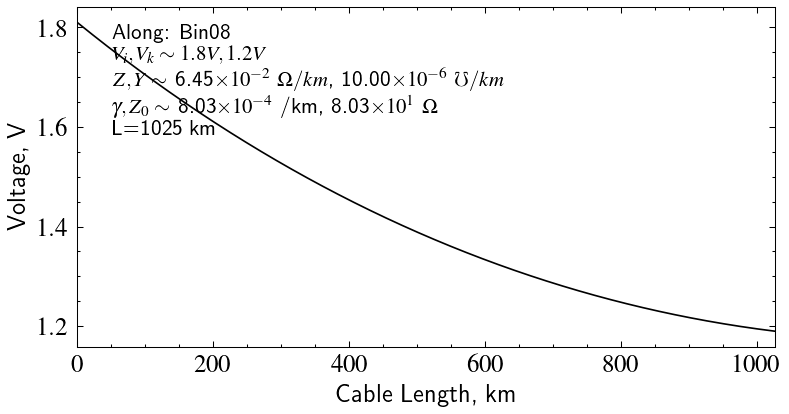

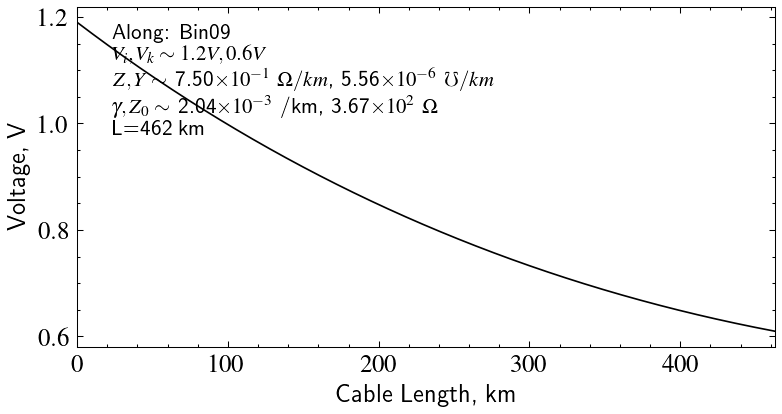

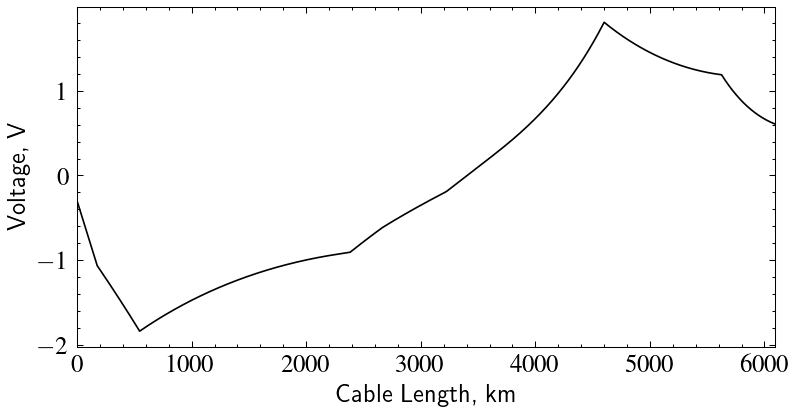

In [4]:
# Input Control JSON for Ocean-Earth model
ICJ = {
    "sid": 5,
    "opcode": 0,
    "Bfield": {
        "data_sources": { # Source of the datasets
            "stns": ["FRD", "HAD", "STJ"],
            "sources": [ # Linking data files to stations
                "input/data/1989/FRD_19890312_XYZ.txt",
                "input/data/1989/FRD_19890313_XYZ.txt",
                "input/data/1989/FRD_19890314_XYZ.txt",
                "input/data/1989/HAD_19890312_HDZ.txt",
                "input/data/1989/HAD_19890313_HDZ.txt",
                "input/data/1989/HAD_19890314_HDZ.txt",
                "input/data/1989/STJ_19890312_XYZ.txt",
                "input/data/1989/STJ_19890313_XYZ.txt",
                "input/data/1989/STJ_19890314_XYZ.txt",
            ],
        },
        "tapering": 0.1 # Tapering coefficient
    },
    "cable": { # Cable description
        "cable_sections": [ # Description of cable sections
            {
                "sec_id": 1,
                "station": "FRD",
                "elec_params": {
                    "earth_model": "CS-W", # CS-W Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 100, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 39.6, "lon": -74.33
                    },
                    "fin": { # Final lat/lon
                        "lat": 38.79, "lon": -72.62
                    }
                },
            },
            {
                "sec_id": 2,
                "station": "FRD",
                "elec_params": {
                    "earth_model": "DO-1", # DO-1 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 38.79, "lon": -72.62
                    },
                    "fin": { # Final lat/lon
                        "lat": 37.11, "lon": -68.94
                    }
                },
            },
            {
                "sec_id": 3,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-2", # DO-2 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 5200, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 37.11, "lon": -68.94
                    },
                    "fin": { # Final lat/lon
                        "lat": 39.80, "lon": -48.20
                    }
                },
            },
            {
                "sec_id": 4,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-3", # DO-3 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 39.80, "lon": -48.20
                    },
                    "fin": { # Final lat/lon
                        "lat": 40.81, "lon": -45.19
                    }
                },
            },
            {
                "sec_id": 5,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-4", # DO-4 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4800, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 40.81, "lon": -45.19
                    },
                    "fin": { # Final lat/lon
                        "lat": 43.15, "lon": -39.16
                    }
                },
            },
            {
                "sec_id": 6,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "DO-5", # DO-5 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 43.15, "lon": -39.16
                    },
                    "fin": { # Final lat/lon
                        "lat": 44.83, "lon": -34.48
                    }
                },
            },
            {
                "sec_id": 7,
                "station": "STJ",
                "elec_params": {
                    "earth_model": "MAR", # MAR Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 3000, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 44.83, "lon": -34.48
                    },
                    "fin": { # Final lat/lon
                        "lat": 46.51, "lon": -22.43
                    }
                },
            },
            {
                "sec_id": 8,
                "station": "HAD",
                "elec_params": {
                    "earth_model": "DO-6", # DO-6 Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 4500, # Ocean depth in meters
                    "ocean_resistivity": 0.3 # Ocean resistivity
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 46.51, "lon": -22.43
                    },
                    "fin": { # Final lat/lon
                        "lat": 47.85, "lon": -9.05
                    }
                },
            },
            {
                "sec_id": 9,
                "station": "HAD",
                "elec_params": {
                    "earth_model": "CS-E", # CS-E Earth model stored in 'config/conductivity.json'
                    "ocean_depth": 100, # Ocean depth in meters
                    "ocean_resistivity": 0.3, # Ocean resistivity
                    "active_termination": True # Active termination on the East Edge
                },
                "edge_loc":{ # Cabel section edge location
                    "ini": { # Initial lat/lon
                        "lat": 47.85, "lon": -9.05
                    },
                    "fin": { # Final lat/lon
                        "lat": 50.79, "lon": -4.55
                    }
                },
            }
        ],
        "cable_pot_plot_index": 0
    },
    "out_dir": "tmp/out/005/", # Output directory
    "opname": "March 1989 Storm Analysis"
}

control = RecursiveNamespace(**ICJ)

# Any modification on control JSON:
# Modify the control JSON based on DO-2 from STJ to FRD
#control.cable.cable_sections[2].station = "FRD"
# Please change this part before running.


cable = CableAnalysis(control.Bfield, control.cable, control.out_dir)
cable.run()
params = cable.cbl.tot_params

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

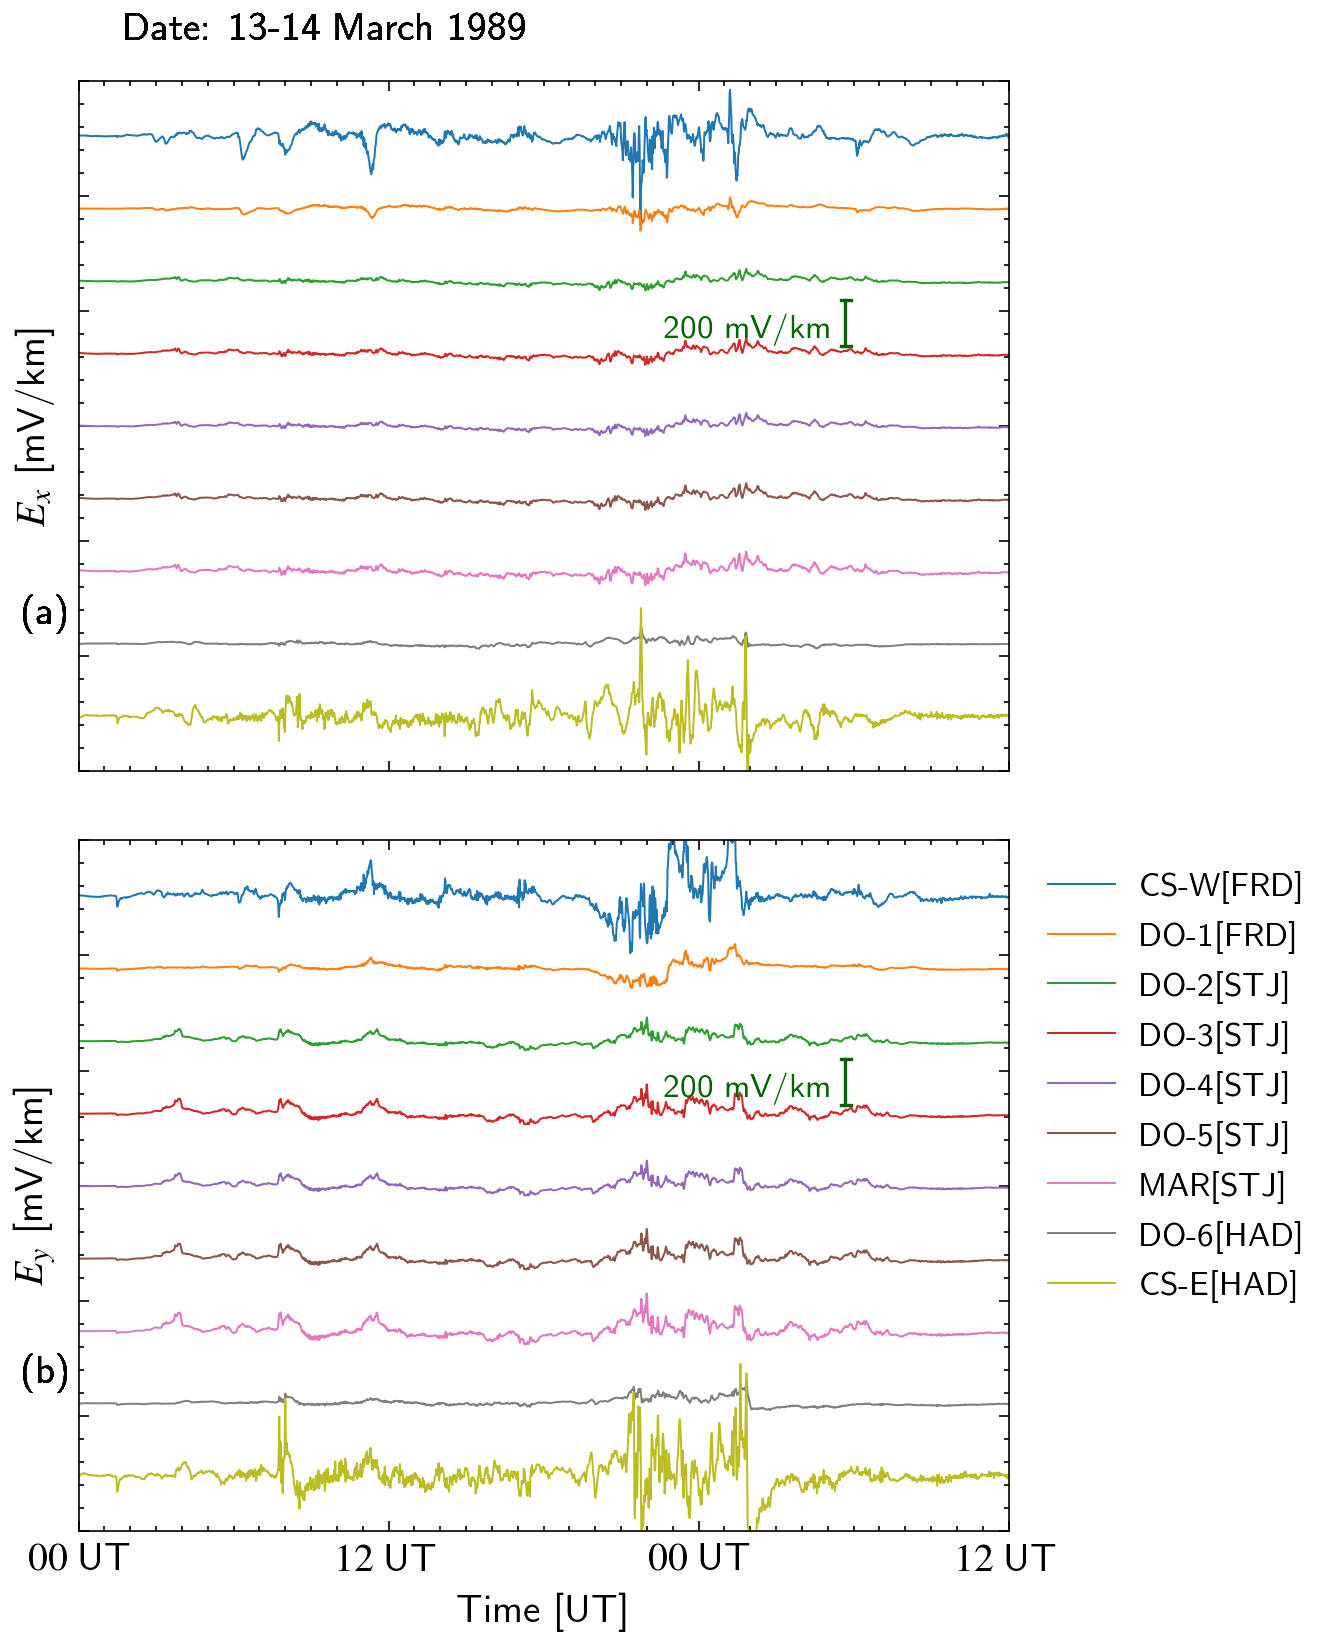

In [5]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=240, figsize=(5, 8), sharex=True)
multiplier, colors = np.array([4,3,2,1,0,-1,-2,-3,-4])*3.5, ["r", "k", "b"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
base=90
for i in range(9):
    ax = axes[0]
    ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["E.X.%02d"%(i)]-np.mean(params["E.X.%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6
    )
    ax.set_xticklabels([])
    ax.set_ylabel(r"$E_x$ [mV/km]", fontdict={"color": "k"})
    ax.set_ylim(-1500,1500)
    ax.text(-0.06,0.2,"(a)",ha="left",va="bottom",transform=ax.transAxes)
    if i==0:
        ax.axvline(params.index.tolist()[-1100], ymin=18.5/30, ymax=20.5/30, 
                   color = "darkgreen", drawstyle="steps-mid")
        ax.axhline(350, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.axhline(550, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.text(params.index.tolist()[2800], 425, "200 mV/km", ha="left", va="center", 
                fontdict={"color": "darkgreen", "size":10})
    ax.set_yticklabels([])
    ax.legend(loc=2)
    ax = axes[1]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    txt = r"%s[%s]"%(segment_name[i], control.cable.cable_sections[i].station)
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["E.Y.%02d"%(i)]-np.mean(params["E.Y.%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6, 
        label=txt
    )
    ax.set_ylabel(r"$E_y$ [mV/km]", fontdict={"color": "k"})
    if i==0:
        ax.axvline(params.index.tolist()[-1100], ymin=18.5/30, ymax=20.5/30, 
                   color = "darkgreen", drawstyle="steps-mid")
        ax.axhline(350, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.axhline(550, xmin=0.82, xmax=0.82+1e-2, color = "darkgreen")
        ax.text(params.index.tolist()[2800], 425, "200 mV/km", ha="left", va="center", 
                fontdict={"color": "darkgreen", "size":10})
        #ax.axvline(frame.index.tolist()[2000], ymin=4/6, ymax=5/6, color = "darkgreen", drawstyle="steps-mid")
        #ax.axhline(2000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        #ax.axhline(1000, xmin=0.25, xmax=0.25+2e-2, color = "darkgreen")
        #ax.text(frame.index.tolist()[1970], 1500, "1000 nT", ha="right", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-1500,1500)
    ax.set_yticklabels([])
    ax.text(-0.06,0.2,"(b)",ha="left",va="bottom",transform=ax.transAxes)
axes[1].set_xlabel("Time [UT]")
axes[1].legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=10)
fig.subplots_adjust(wspace=.1, hspace=.1)
fig.savefig("tmp/Exy.Field.png", bbox_inches="tight")


Text(1989-03-13 15:10:00, 480, '100 V')

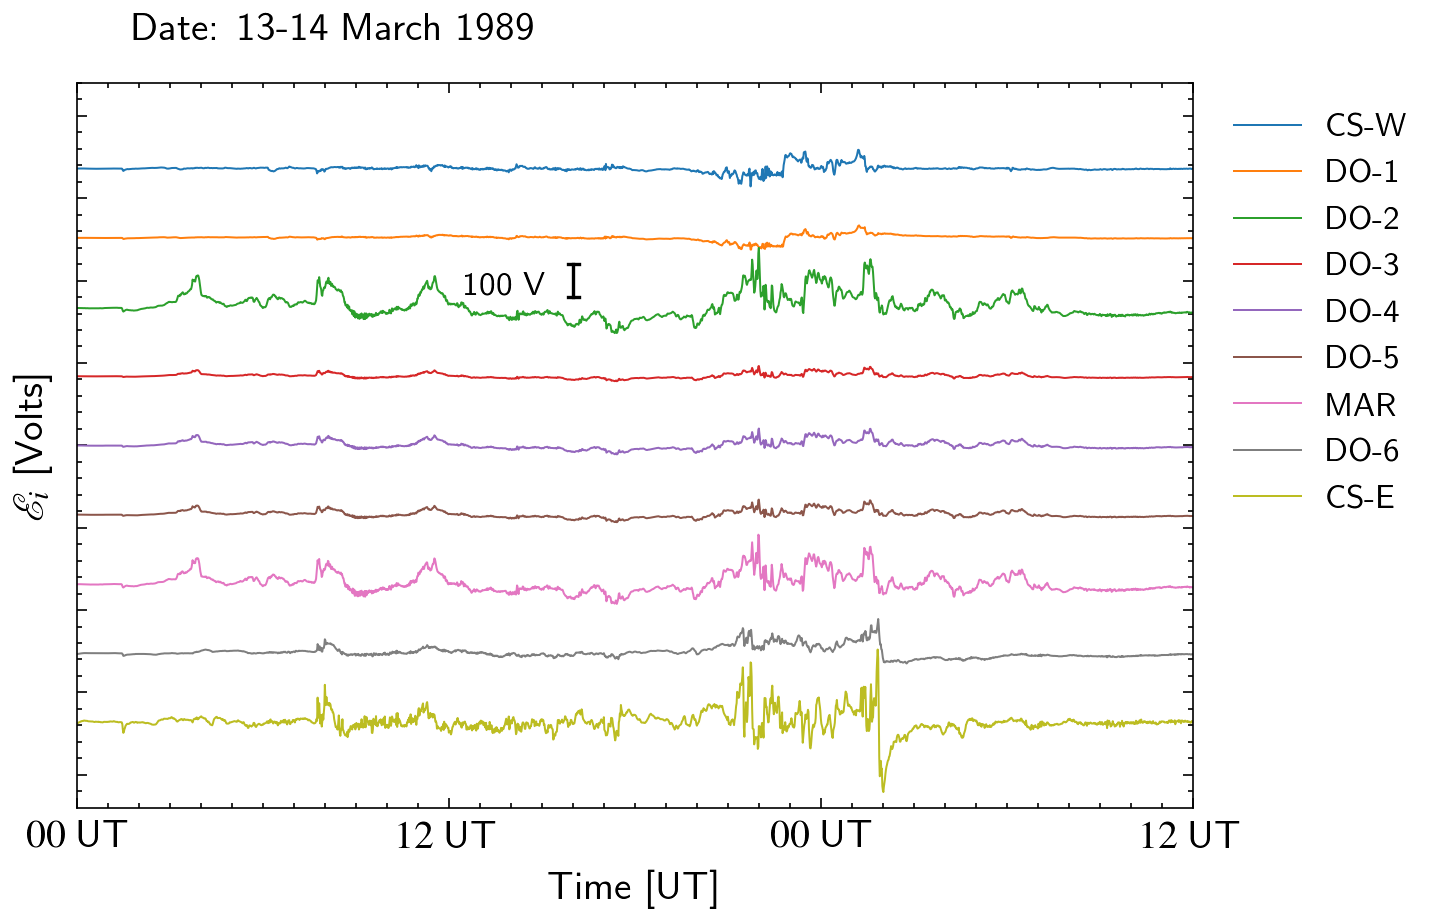

In [6]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=240, figsize=(6, 4))
multiplier = np.array([4,3,2,1,0,-1,-2,-3,-4])*7
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
#ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.set_ylabel(r"$\mathcal{E}_{i}$ [Volts]", fontdict={"color": "k"})
ax.set_xlabel(r"Time [UT]", fontdict={"color": "k"})
base = 30
ax.set_ylim(-1100, 1100)
for i in range(9):
    ax.plot(
        params.index, 
        (base*multiplier[i])+params["V(v).%02d"%(i)]-np.mean(params["V(v).%02d"%(i)]), 
        colors[i], 
        ls="-", 
        lw=0.6,
        label=segment_name[i],
    )
    ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=10)
ax.axvline(params.index.tolist()[2400], ymin=1550/2200, ymax=1650/2200, 
                   color = "k", drawstyle="steps-mid")
ax.axhline(1550-1100, xmin=0.44, xmax=0.44+1e-2, color = "k")
ax.axhline(1650-1100, xmin=0.44, xmax=0.44+1e-2, color = "k")
ax.text(params.index.tolist()[2350], 480, "100 V", ha="right", va="center", 
        fontdict={"color": "k", "size":10})

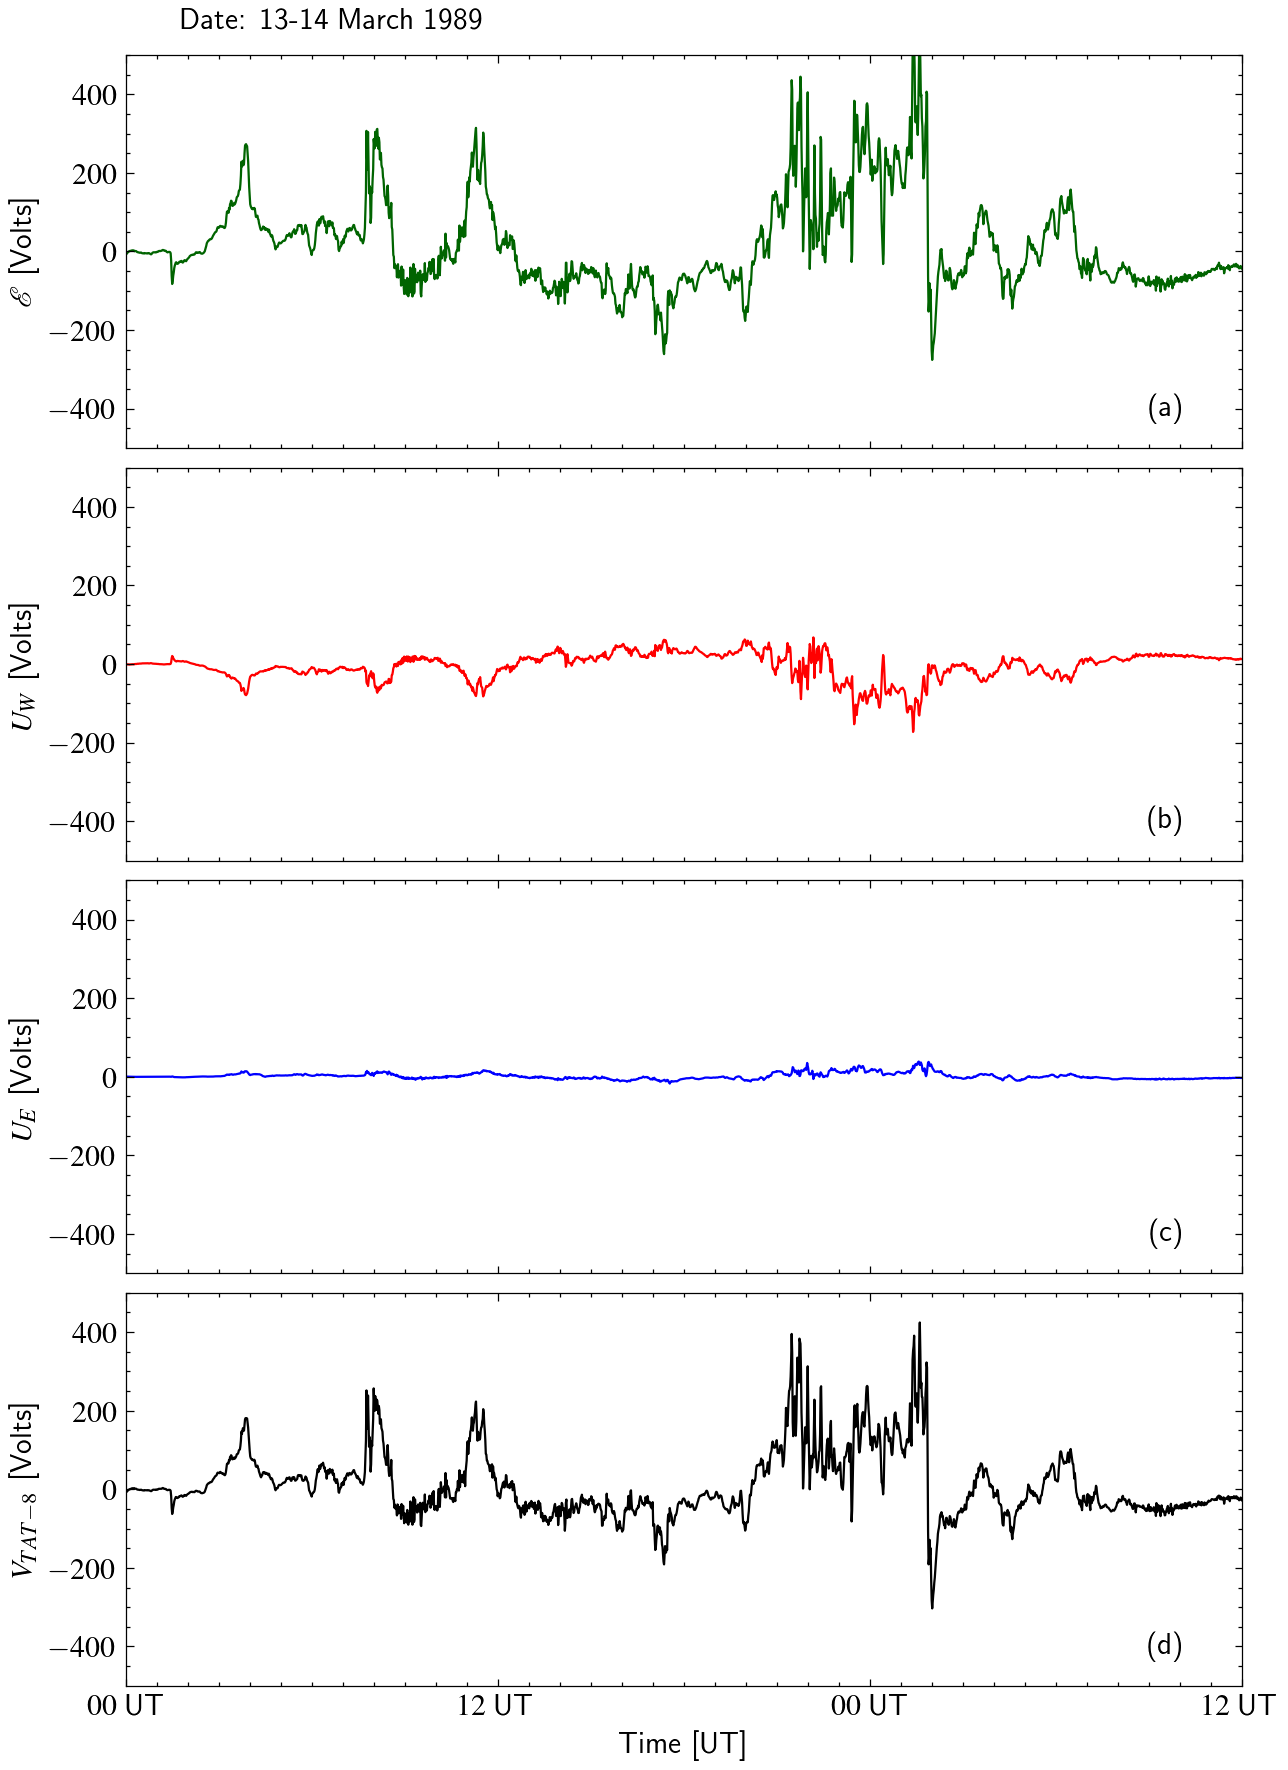

In [7]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=4, ncols=1, dpi=180, figsize=(8, 12), sharex=True)
labs = ["(a)","(b)","(c)","(d)"]
for i, ax in enumerate(axes.ravel()):
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    if i==1:
        ax.set_ylabel(r"$U_W$ [Volts]", fontdict={"color": "k"})
        ax.plot(params.index, params["U0"], "r", ls="-", lw=0.9, zorder=1)
    if i==2:
        ax.set_ylabel(r"$U_E$ [Volts]", fontdict={"color": "k"})
        ax.plot(params.index, params["U1"], "b", ls="-", lw=0.9, zorder=1)
    if i==0:
        ax.set_ylabel(r"$\mathcal{E}$ [Volts]", fontdict={"color": "k"})
        ax.plot(params.index, params["V(v)"], "darkgreen", ls="-", lw=0.9, zorder=1)
        ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
    if i==3:
        ax.set_ylabel(r"$V_{TAT-8}$ [Volts]", fontdict={"color": "k"})
        ax.set_xlabel(r"Time [UT]", fontdict={"color": "k"})
        ax.plot(params.index, params["V(v)"]+(params["U0"]-params["U1"]), "k", ls="-", lw=0.9, zorder=1)
    ax.set_ylim(-500, 500)
    ax.text(0.95,0.1,labs[i],ha="right",va="center",transform=ax.transAxes)
#ax.legend(loc="upper left", fontsize=10)
#fig.autofmt_xdate()
#plt.xticks(rotation=45)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

(0.0, 1.0)

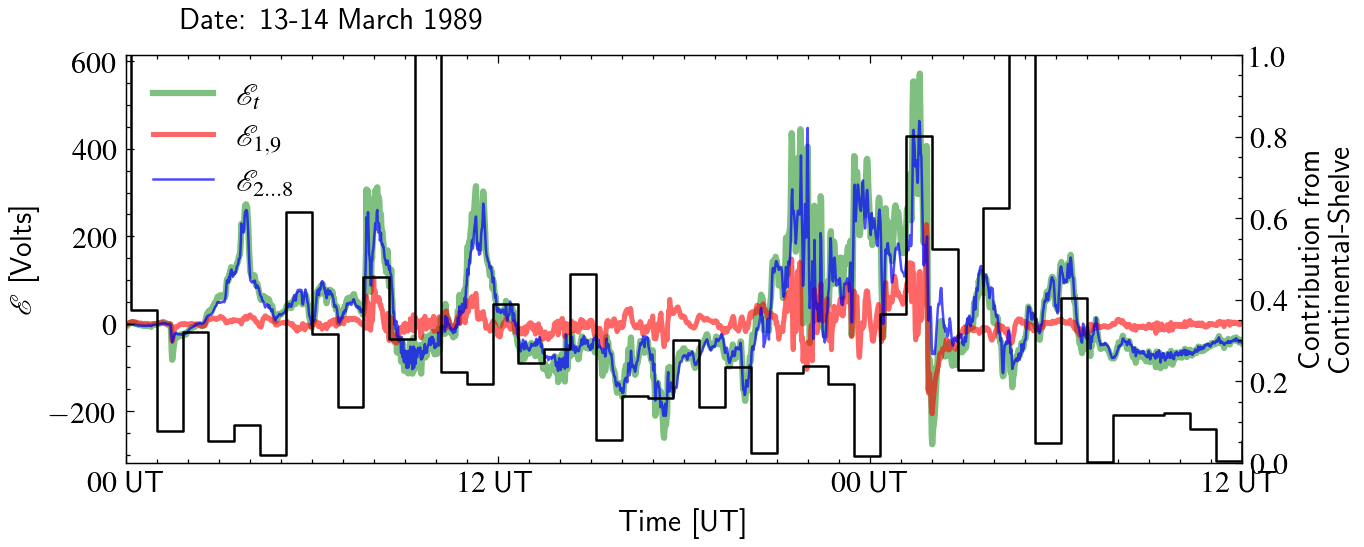

In [19]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=180, figsize=(8, 3), sharex=True)
ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.set_ylabel(r"$\mathcal{E}$ [Volts]", fontdict={"color": "k"})
ax.set_xlabel(r"Time [UT]", fontdict={"color": "k"})
ax.plot(params.index, params["V(v)"], "green", ls="-", lw=2.5, zorder=1, label=r"$\mathcal{E}_t$", alpha=0.5)
ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
ax.plot(params.index, params["V(v).00"]+params["V(v).08"], "red", ls="-", lw=2., zorder=1, 
        label=r"$\mathcal{E}_{1,9}$", alpha=0.6)
ax.plot(params.index, 
        params["V(v).01"]+params["V(v).02"]+params["V(v).03"]+params["V(v).04"]+params["V(v).05"]+params["V(v).06"]+
        params["V(v).07"], 
        "b", ls="-", lw=1., zorder=1.5, label=r"$\mathcal{E}_{2...8}$", alpha=0.7)
ax.legend(loc=2)
ax = ax.twinx()
ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.set_ylabel("Contribution from \n Continental-Shelve", fontdict={"color": "k"})
ax.plot(params.index[::50], 
        np.abs(((params["V(v).00"]+params["V(v).08"])/params["V(v)"]))[::50], 
        "k", ls="-", lw=1., zorder=1, label=r"$\mathcal{E}_{2...8}$", drawstyle="steps-pre")
ax.set_ylim(0,1)

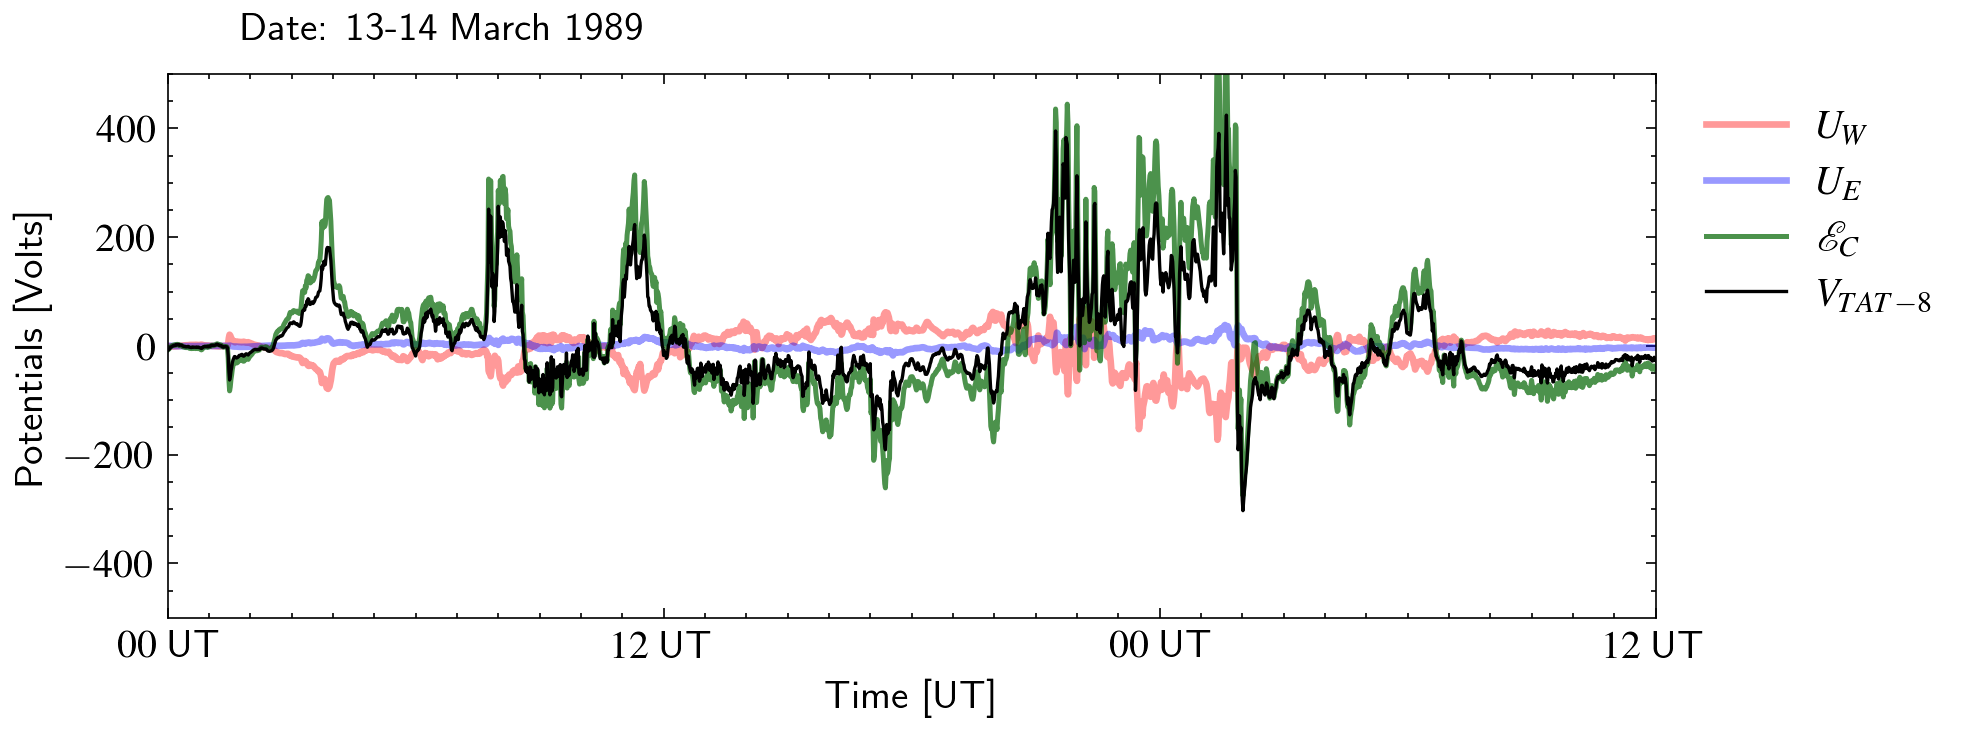

In [9]:
mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=240, figsize=(8, 3), sharex=True)
ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.plot(params.index, params["U0"], "r", ls="-", lw=2, alpha=0.4, label=r"$U_W$")
ax.plot(params.index, params["U1"], "b", ls="-", lw=2, alpha=0.4, label=r"$U_E$")
ax.plot(params.index, params["V(v)"], "darkgreen", ls="-", lw=1.5, label=r"$\mathcal{E}_C$", alpha=0.7)
ax.plot(params.index, params["V(v)"]+(params["U0"]-params["U1"]), "k", ls="-", lw=1., label=r"$V_{TAT-8}$")
ax.set_ylim(-500, 500)
ax.set_xlabel("Time [UT]")
ax.set_ylabel("Potentials [Volts]")
ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

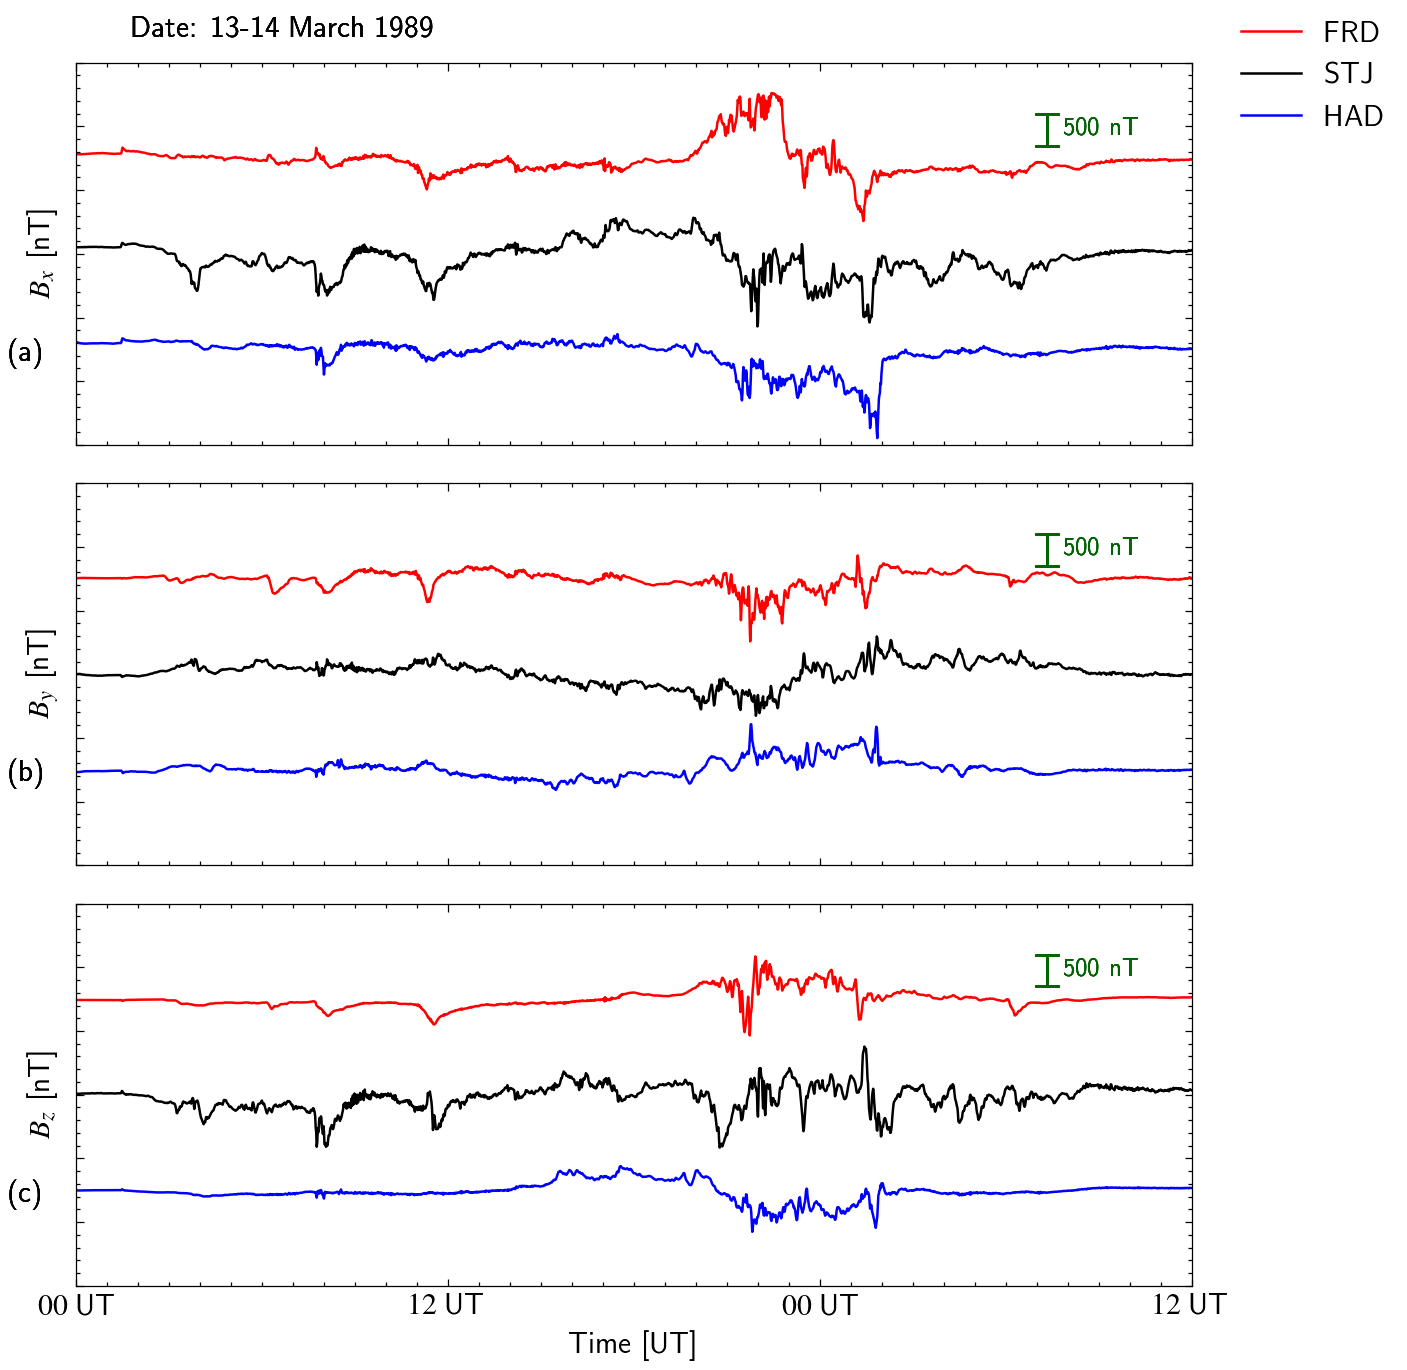

In [10]:
# Plots for Bx,y,z
stns, coords = ["FRD", "STJ", "HAD"], ["XYZ", "XYZ", "HDZ"]
db="input/data/{year}/"
dates, frames = [dt.datetime(1989,3,12),dt.datetime(1989,3,13),dt.datetime(1989,3,14)], {}
for stn, coord in zip(stns, coords):
    o = pd.DataFrame()
    for d in dates:
        f = db.format(year=d.year) + "{stn}_{date}_{coord}.txt".format(stn=stn, 
                                                                       date=d.strftime("%Y%m%d"), 
                                                                       coord=coord)
        o = pd.concat([o, bezpy.mag.read_iaga(f)])
    frames[stn] = o

mpl.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize":12, "font.size":12})
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=180, figsize=(8, 3*len(stns)))
multiplier, colors = [1.5, 0, -1.5], ["r", "k", "b"]
base=1000
for i, stn in enumerate(stns):
    frame = frames[stn]
    ax = axes[0]
    ax.text(0.05, 1.05, "Date: 13-14 March 1989", ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    ax.plot(frame.index, (base*multiplier[i])+frame.X-np.mean(frame.X), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_x$ [nT]", fontdict={"color": "k"})
    ax.set_ylim(-3000,3000)
    ax.axvline(frame.index.tolist()[-1000], ymin=4700/6000, ymax=5200/6000, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2200, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.axhline(1700, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[-970], 1950, "500 nT", ha="left", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.legend(bbox_to_anchor=(1.02, 0.75))
    ax.text(-0.06,0.2,"(a)",ha="left",va="bottom",transform=ax.transAxes)
    ax = axes[1]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    ax.plot(frame.index, (base*multiplier[i])+frame.Y-np.mean(frame.Y), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_y$ [nT]", fontdict={"color": "k"})
    ax.axvline(frame.index.tolist()[-1000], ymin=4700/6000, ymax=5200/6000, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2200, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.axhline(1700, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[-970], 1950, "500 nT", ha="left", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-3000,3000)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.text(-0.06,0.2,"(b)",ha="left",va="bottom",transform=ax.transAxes)
    ax = axes[2]
    ax.set_xlim(dt.datetime(1989,3,13), dt.datetime(1989,3,14,12))
    ax.xaxis.set_major_formatter(DateFormatter(r"%H UT"))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
    #ax.xaxis.set_minor_formatter(DateFormatter("%H UT"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    ax.plot(frame.index, (base*multiplier[i])+frame.Z-np.mean(frame.Z), colors[i], ls="-", lw=1., label=stn.upper())
    ax.set_ylabel(r"$B_z$ [nT]", fontdict={"color": "k"})
    ax.axvline(frame.index.tolist()[-1000], ymin=4700/6000, ymax=5200/6000, color = "darkgreen", drawstyle="steps-mid")
    ax.axhline(2200, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.axhline(1700, xmin=0.86, xmax=0.86+2e-2, color = "darkgreen")
    ax.text(frame.index.tolist()[-970], 1950, "500 nT", ha="left", va="center", fontdict={"color": "darkgreen", "size":10})
    ax.set_ylim(-3000,3000)
    ax.set_yticklabels([])
    ax.text(-0.06,0.2,"(c)",ha="left",va="bottom",transform=ax.transAxes)
axes[2].set_xlabel("Time [UT]")
fig.subplots_adjust(wspace=.1, hspace=.1)
fig.savefig("tmp/Bxy.Field.png", bbox_inches="tight")